In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os 
import pickle
from sklearn.metrics import roc_auc_score, log_loss

In [2]:
# either keep sigma = 10 and do seed = 0, and show log_loss (auc not the greatest)
# or drop sigma = 10 --> then you dominate. 
# sigma = 10-1000 and all alpha is an ok setting for seed = 0

In [102]:
base_dir_mit = '/data/ddmg/scate/multiple_shortcut/waterbirds'
base_dir_gl = '/nfs/turbo/coe-soto/mmakar/multiple_shortcut/waterbirds'
if os.path.exists(base_dir_mit):
    base_dir = base_dir_mit
elif os.path.exists(base_dir_gl):
    base_dir = base_dir_gl 
    
pixel = 128 
batch_size = 64 
py1y0 = 0.9
seed_list = [4]

In [103]:

def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

def get_per_dist_metrics(df):
    all_results = []
    for dist in [0.1, 0.5, 0.9]:
        curr_df = df[(df.dist==dist)]
        curr_eval = {'dist': dist}
        curr_eval['auc'] = roc_auc_score(curr_df.y0, curr_df.pred0)
#         curr_eval['acc'] = np.mean(1.0 * (curr_df.y0 == curr_df.pred_class))
        curr_eval['log_loss'] = log_loss(curr_df.y0, curr_df.pred0)
        
        all_results.append(curr_eval)
    return pd.DataFrame(all_results)
    

def get_all_dist_metrics(random_seeds, model_name, xv_mode, v_dim):
    all_eval = []
    for random_seed in random_seeds: 
        curr_pred = pd.read_csv(
            (f'{base_dir}/final_models/opt_pred_rs{random_seed}_{model_name}_{xv_mode}'
             f'_pix{pixel}_bs{batch_size}_vdim{v_dim}.csv')) 
#         curr_pred = pd.read_csv(
#         ('/nfs/turbo/coe-soto/.snapshot/coe-soto-daily_2022-05-11_01-30/'
#          'mmakar/multiple_shortcut/waterbirds/final_models/'
#          f'opt_pred_rs{random_seed}_{model_name}_{xv_mode}'
#          f'_pix{pixel}_bs{batch_size}_vdim{v_dim}.csv'
#         ))
        all_eval.append(get_per_dist_metrics(curr_pred))
        
    all_eval = pd.concat(all_eval, ignore_index=True)

    if len(random_seeds) > 1: 
        all_eval = all_eval.groupby('dist').agg(
            [np.mean, np.std, np.median, percentile(25), percentile(75)]
        ).reset_index()
        all_eval.columns = ['_'.join(col).strip() for col in all_eval.columns.values]
        all_eval.rename(columns={'dist_': 'dist'}, inplace=True)
        for col in all_eval.columns:
            if 'std' in col:
                all_eval[col] = all_eval[col]/np.sqrt(len(random_seeds)*1.0)
    return all_eval
        
        
def get_all_dist_metrics_all_models(random_seeds, model_name, xv_mode, v_dim):
    if len(random_seeds)>1:
        raise NotImplementedError("dont have this")
    random_seed = random_seeds[0]
    all_eval = []
    curr_pred = pd.read_csv(
        (f'{base_dir}/final_models/all_pred_{model_name}_{xv_mode}'
         f'_pix{pixel}_bs{batch_size}_vdim{v_dim}.csv')) 
    for model in curr_pred.model.unique().tolist():
        model_pred = curr_pred[(curr_pred.model == model)]
        model_eval = get_per_dist_metrics(model_pred)
        model_eval['model'] = f'{model_name}-{model[:5]}'
        model_eval['hash_string'] = model
        all_eval.append(model_eval)
        
    all_eval = pd.concat(all_eval, ignore_index=True)
    return all_eval
        

In [104]:
model_name = 'unweighted_baseline'
xv_mode = 'classic'
v_dim = 0
uw_eval = get_all_dist_metrics(seed_list, model_name, xv_mode, v_dim)
uw_eval['Model'] = 'L2'
# uw_eval = get_all_dist_metrics_all_models(random_seed, model_name, xv_mode, v_dim)


In [105]:
model_name = 'weighted_baseline'
xv_mode = 'classic'
v_dim = 1 
w1_eval = get_all_dist_metrics(seed_list, model_name, xv_mode, v_dim)
w1_eval['Model'] = 'W-L2-HDX'

In [106]:
model_name = 'weighted_baseline'
xv_mode = 'classic'
v_dim = 2 
w2_eval = get_all_dist_metrics(seed_list, model_name, xv_mode, v_dim)
w2_eval['Model'] = 'W-L2-S'

In [107]:
model_name = 'weighted_baseline'
xv_mode = 'classic'
v_dim = 12
w12_eval = get_all_dist_metrics(seed_list, model_name, xv_mode, v_dim)
# w12_eval = get_all_dist_metrics_all_models(random_seed, model_name, xv_mode, v_dim)
w12_eval['Model'] = 'W-L2-FullV'


In [108]:
model_name = 'weighted_hsic'
xv_mode = 'two_step'
v_dim = 1
wh1_eval = get_all_dist_metrics(seed_list, model_name, xv_mode, v_dim)
# wh1_eval = get_all_dist_metrics_all_models(random_seed, model_name, xv_mode, v_dim)
wh1_eval['Model'] = 'W-HSIC-HDX'

In [109]:
model_name = 'weighted_hsic'
xv_mode = 'two_step'
v_dim = 2
wh2_eval = get_all_dist_metrics(seed_list, model_name, xv_mode, v_dim)
# wh2_eval = get_all_dist_metrics_all_models(seed_list, model_name, xv_mode, v_dim)
# wh2_eval_lst_or = [wh2_eval[(wh2_eval.model== model)] for model in wh2_eval.model.unique().tolist()]
# wh2_eval_lst = [df for df in wh2_eval_lst_or if df.auc[(df.dist==0.1)].values[0] > 0.69 ]
# wh2_eval_lst = [df for df in wh2_eval_lst if df.auc[(df.dist==0.9)].values[0] > 0.79 ]
# wh2_eval_lst = [wh2_eval]
wh2_eval['Model'] = 'Ours'

In [110]:
model_name = 'weighted_hsic'
xv_mode = 'two_step'
v_dim = 12
wh12_eval = get_all_dist_metrics(seed_list, model_name, xv_mode, v_dim)
# wh12_eval = get_all_dist_metrics_all_models(seed_list, model_name, xv_mode, v_dim)
wh12_eval['Model'] = 'W-HSIC-FullV'

In [111]:
df_table = pd.concat([uw_eval, w1_eval, w2_eval, w12_eval, wh1_eval, wh12_eval, wh2_eval], axis=0)
if len(seed_list) > 1 :
    df_table = df_table[['Model', 'dist', 'auc_mean', 'auc_std']]
    df_table['AUROC (STE)'] = df_table.auc_mean.round(2).astype(str)+ \
        " (" + df_table.auc_std.round(3).astype(str) + ") "

    df_table.drop(['auc_mean', 'auc_std'], axis=1, inplace=True)
    res_table = df_table.pivot(index='Model', columns='dist', values='AUROC (STE)')
else: 
    df_table = df_table[['Model', 'dist', 'auc']]
    df_table['AUROC (STE)'] = df_table.auc.round(2)
    df_table.drop(['auc'], axis=1, inplace=True)
    res_table = df_table.pivot(index='Model', columns='dist', values='AUROC (STE)')

res_table = res_table.reindex(['L2', 'W-L2-FullV', 'W-L2-HDX', 'W-L2-S', 'W-HSIC-FullV', 'W-HSIC-HDX', 'Ours'])
res_table = res_table.reset_index()

In [112]:
df_table.head()

,Model,dist,AUROC (STE)
0,L2,0.1,0.58
1,L2,0.5,0.66
2,L2,0.9,0.77
0,W-L2-HDX,0.1,0.71
1,W-L2-HDX,0.5,0.77


In [113]:
res_table = res_table.rename(columns={0.1: 'Flipped', 0.5: 'Ideal $(P^\circ)$', 0.9: 'Same $(P_s)$'})

In [114]:
print(res_table.to_latex(index=False, escape=False))

\begin{tabular}{lrrr}
\toprule
       Model &  Flipped &  Ideal $(P^\circ)$ &  Same $(P_s)$ \\
\midrule
          L2 &     0.58 &               0.66 &          0.77 \\
  W-L2-FullV &     0.60 &               0.72 &          0.82 \\
    W-L2-HDX &     0.71 &               0.77 &          0.85 \\
      W-L2-S &     0.58 &               0.69 &          0.82 \\
W-HSIC-FullV &     0.62 &               0.74 &          0.83 \\
  W-HSIC-HDX &     0.64 &               0.72 &          0.82 \\
        Ours &     0.68 &               0.77 &          0.86 \\
\bottomrule
\end{tabular}



In [115]:
eval_perf = {
    'uw_l2': uw_eval,
    'w1_l2': w1_eval,
    'w2_l2': w2_eval,
    'w12_l2': w12_eval,
    'w1_hsic':wh1_eval,
    'w12_hsic':wh12_eval,
    'w2_hsic': wh2_eval
}

In [116]:
# pickle.dump(eval_perf, open(f'{base_dir}/final_models/final_plot_results.pkl', 'wb'))

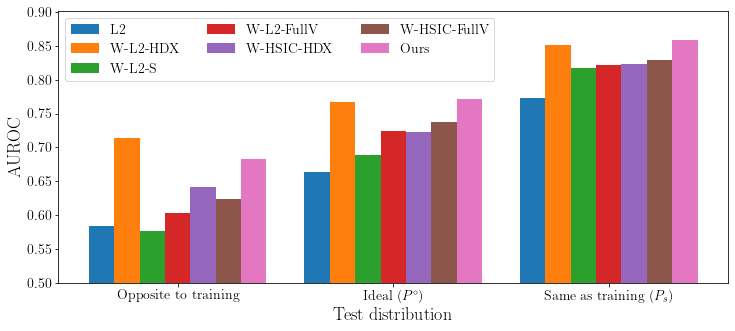

In [117]:
metric = 'auc'
stat = 'mean'
fig = plt.figure(figsize=(12, 5))

font = {'size': 14, 'family': 'serif', 'serif': 'Computer Modern Roman'}
plt.rc('font', **font)
plt.rc('text', usetex=True)

x_loc = [0, 0.85, 1.7]

width = 0.1
bar_width = 0.1
# df_lst = [uw_eval, w1_eval, w2_eval, w12_eval, wh1_eval, wh12_eval] + wh2_eval_lst
# lab_lst = ['DNN', 'wDNN 1', 'wDNN 2', 'wDNN 12', 'whsic 1', 'whsic 12'] + [
#     f'o{i}' for i in range(len(wh2_eval_lst_or))]

df_lst = [uw_eval, w1_eval, w2_eval, w12_eval, wh1_eval, wh12_eval, wh2_eval] 
lab_lst = ['L2', 'W-L2-HDX',  'W-L2-S', 'W-L2-FullV', 'W-HSIC-HDX', 'W-HSIC-FullV', 'Ours']
col_lst = ['black', '#ABABAB', '#FF9900', '#336633', '#3333CC',  '#9900CC', '#CC3300'] 


for df_i, df in enumerate(df_lst):
    if f'{metric}_{stat}' in df.columns:
        if df.Model.loc[0] == 'W-L2-FullV':
            x_tick_loc = [i + width * df_i for i in x_loc]
        plt.bar([i + width * df_i for i in x_loc], df[f'{metric}_{stat}'], 
                     width=bar_width, yerr= df[f'{metric}_std'], label=lab_lst[df_i], 
                     capsize= 5, edgecolor= 'black', 
                color = col_lst[df_i], alpha =0.8)
    else: 
        plt.bar([i + width * df_i for i in x_loc], df[metric], 
                     width=bar_width, label=lab_lst[df_i], 
                     capsize= 5)
    
plt.ylim(bottom=0.5)
plt.legend(loc = 'upper left', ncol = 3)
plt.ylabel("AUROC", size = 18)
plt.xlabel("Test distribution", size=18)
_ = plt.xticks(x_tick_loc, labels = ['Opposite to training', 'Ideal $(P^\circ)$', 'Same as training $(P_s)$'])

[0, 1, 2]


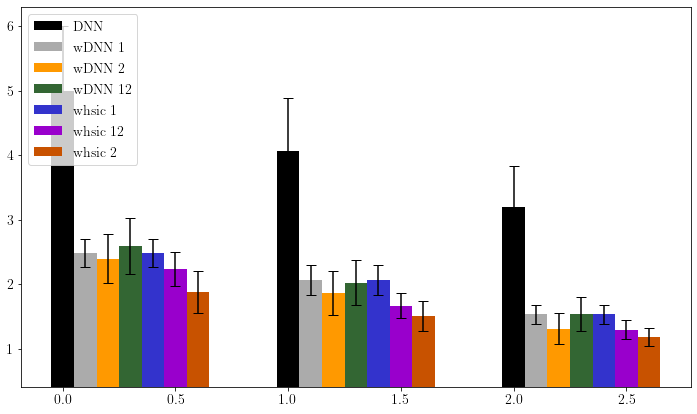

In [150]:
metric = 'log_loss'
stat = 'mean'
fig = plt.figure(figsize=(12, 7))

x_loc = [i for i in range(len(w1_eval.dist.unique()))]
print(x_loc)

width = 0.1
bar_width = 0.1
df_lst = [uw_eval, wh1_eval, w2_eval, w12_eval, wh1_eval, wh12_eval, wh2_eval] 
lab_lst = ['DNN', 'wDNN 1',  'wDNN 2', 'wDNN 12', 'whsic 1', 'whsic 12', 'whsic 2']
col_lst = ['black', '#ABABAB', '#FF9900', '#336633', '#3333CC',  '#9900CC', '#C85200'] 


for df_i, df in enumerate(df_lst):
    if f'{metric}_{stat}' in df.columns:
        plt.bar([i + width * df_i for i in x_loc], df[f'{metric}_{stat}'], 
                     width=bar_width, yerr= df[f'{metric}_std'], label=lab_lst[df_i], 
                     capsize= 5, color = col_lst[df_i])
    else: 
        plt.bar([i + width * df_i for i in x_loc], df[metric], 
                     width=bar_width, label=lab_lst[df_i], 
                     capsize= 5)
    
plt.ylim(bottom=0.4)
plt.legend(loc = 'upper left')


In [36]:
all_results = pd.read_csv(
    "/nfs/turbo/coe-soto/mmakar/multiple_shortcut/waterbirds/final_models/all_hsic_perm_vdim2.csv")

In [90]:
t1_error = 0.5
all_results['quant'] = np.quantile(
    all_results[[col for col in all_results.columns if "hsicp" in col]].values,
    1 - t1_error, axis=1)
all_results['significant'] = all_results.hsic <= all_results.quant

In [91]:
all_results[((all_results.random_seed==6) & (all_results.sigma==10.0))][['alpha', 'sigma', 'hsic', 'quant', 'significant']]

,alpha,sigma,hsic,quant,significant
22,1000.0,10.0,0.000143,0.000135,False
58,100000.0,10.0,0.000017,0.000016,False
93,10000000.0,10.0,0.000002,0.000002,False


In [73]:
all_results[(all_results.hsic==0.001535)]

,random_seed,alpha,sigma,hsic,significant,hsicp0,hsicp1,hsicp2,hsicp3,hsicp4,...,hsicp91,hsicp92,hsicp93,hsicp94,hsicp95,hsicp96,hsicp97,hsicp98,hsicp99,quant


In [93]:
all_results[
    ((all_results.random_seed==6) & (all_results.sigma==10.0) & (all_results.alpha==10000000.0))
][[col for col in all_results.columns if "hsicp" in col]].values

array([[2.2649765e-06, 2.1457672e-06, 2.0265580e-06, 2.0265580e-06,
        2.0265580e-06, 2.2649765e-06, 2.1457672e-06, 2.0265580e-06,
        2.0265580e-06, 1.9073486e-06, 2.0265580e-06, 2.1457672e-06,
        2.1457672e-06, 2.1457672e-06, 2.2649765e-06, 2.2649765e-06,
        1.7881393e-06, 2.2649765e-06, 2.1457672e-06, 2.1457672e-06,
        2.0265580e-06, 2.2649765e-06, 2.1457672e-06, 1.9073486e-06,
        1.9073486e-06, 2.3841858e-06, 2.0265580e-06, 2.2649765e-06,
        1.9073486e-06, 1.9073486e-06, 2.0265580e-06, 2.3841858e-06,
        1.9073486e-06, 2.0265580e-06, 2.0265580e-06, 2.3841858e-06,
        2.0265580e-06, 2.1457672e-06, 2.0265580e-06, 2.0265580e-06,
        1.6689300e-06, 2.3841858e-06, 2.2649765e-06, 2.3841858e-06,
        2.5033950e-06, 1.9073486e-06, 2.1457672e-06, 2.0265580e-06,
        2.5033950e-06, 1.7881393e-06, 2.1457672e-06, 1.6689300e-06,
        2.1457672e-06, 2.0265580e-06, 2.2649765e-06, 2.2649765e-06,
        2.2649765e-06, 2.2649765e-06, 1.9073486e